In [2]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

# Experimental information

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**
*  anti-His tag spots: All of the recombinant proteins that are used to coat the plates have hexa-His tags cloned into them, and the coat protein in these spots is anti-His. In this experiment, all of the recombinant antigens were spotted here on the anti-His coated spot, then serum was added so that the spot is representative of a polyclonal response. There was more cross-reactivity than expected and **this control will not be used in the future covid plates.**

# Data format conventions

For ease of reading and manipulating data, all data is converted in $n$-dimensional arrays. 
* Well metadata is #wells $\times$ 4 array. 
* antigen metadata is  #rows $\times$ #columns in the array.
* background corrected ODs is a 4D float array (Well row x Well column x Array row x Array column).

# TODO

####  All methods/transformations should use simple data structures, e.g., use numpy array as input and generate numpy array as output.

* defs: 
    * read_data: parse csv and xls to return array of well information, antigen information, and antigenODs.
    * plot_OD(antigen, sera, dilutions), antigen can be fiducial, positive control, negative control, or diagnostic. 
    * compareODs(antigens,sera), plots to compare ODs (antibody amount) across sera
    * estimateTiter(antigen, serum) dilution at which antigen becomes undetectable in given serum
 

# Read identity of wells and antigen spots in 2D arrays

In [36]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate'
plateinfo_path=os.path.join(data_folder,'PlateInfoFLuplate.csv')
antigenOD_path=os.path.join(data_folder,'20200327_analyzedPlate','ODs_2020_328_1030.xlsx') #change this for flu plate when available

In [37]:
plateinfo_dataframe=pd.read_csv(plateinfo_path)
plateInfo=plateinfo_dataframe.to_numpy()
pprint(plateInfo)

array([['A1', 'HumanReferencePlasma', 'Control', 1.0],
       ['A2', 'anti-HA mAb MEDI8852', 'Control', 1.0],
       ['A3', 'antii-HA mAb TF19', 'Control', 1.0],
       ['A4', 'MS-Day0', 'Diagnostic', 0.001],
       ['A5', 'MS-Day7', 'Diagnostic', 0.001],
       ['A6', 'MS-Day14', 'Diagnostic', 0.001],
       ['A7', 'MS-Day21', 'Diagnostic', 0.001],
       ['A8', '005-18-Day0', 'Diagnostic', 0.001],
       ['A9', '005-18-Day7', 'Diagnostic', 0.001],
       ['A10', '005-18-Day18', 'Diagnostic', 0.001],
       ['A11', '006-Day7', 'Diagnostic', 0.001],
       ['A12', 'AssayDiluentControl', 'Control', 1.0],
       ['B1', 'HumanReferencePlasma', 'Control', 0.25],
       ['B2', 'anti-HA mAb MEDI8852', 'Control', 0.25],
       ['B3', 'antii-HA mAb TF19', 'Control', 0.25],
       ['B4', 'MS-Day0', 'Diagnostic', 0.00025],
       ['B5', 'MS-Day7', 'Diagnostic', 0.00025],
       ['B6', 'MS-Day14', 'Diagnostic', 0.00025],
       ['B7', 'MS-Day21', 'Diagnostic', 0.00025],
       ['B8', '005-18-Day0

In [38]:
converter = {col: str for col in range(0,7)}
antigens_dataframe=pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter)
antigens=antigens_dataframe.to_numpy()[:,1:] 
pprint(antigens)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate/20200327_analyzedPlate/ODs_2020_328_1030.xlsx'

# Read ODs of all wells in a 4D array (Well row x Well column x Array row x Array column)

## Read data

In [6]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,8)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [7]:
# Read all wells into dictionary and into a 4D numpy array.
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        antigenOD_dataframe=pd.read_excel(antigenOD_path, sheet_name=well_key)
        antigenOD[r,c,:,:]=antigenOD_dataframe.to_numpy()[:,1:] # First column is simply the index. to_numpy returns 6x9 array.
        wellID[r,c] = well_key

## how to index the OD data.

#### direct indexing

In [8]:
pprint(antigenOD[0,0]) # Well A1

array([[1.48690358, 2.29510727, 1.88054858, 2.58605292, 1.28097541,
        2.65749052, 1.4895249 , 1.55835905],
       [1.46043415, 1.85433613, 2.27518306, 2.74934729, 1.43469453,
        2.05008816, 1.69365441, 3.02854479],
       [3.58943717, 1.60508459, 2.58859898, 1.26907949, 5.79775172,
        1.27786073, 1.82586891, 1.66100972],
       [3.3421515 , 1.81320625, 2.73909223, 1.27429019, 2.60367051,
        1.25637504, 2.31202412, 1.60264153],
       [3.43131823, 2.24281023, 3.27112586, 2.11036309, 2.43932369,
        2.12406351, 1.55815716, 4.61593211],
       [1.46372823, 2.1719292 , 3.20397848, 2.05375365, 2.36963313,
        2.01548414, 1.32053514, 1.4020999 ]])


In [9]:
pprint(antigenOD[0,3]) # well A4

array([[1.43988273, 1.3451414 , 2.99774562, 1.21434209, 1.29873839,
        1.08886344, 1.23414691, 1.61283121],
       [1.44550936, 1.15400541, 2.96651674, 1.26165007, 1.09079668,
        1.081295  , 1.06818851, 3.55750328],
       [1.87884234, 1.28353302, 1.11147366, 1.20569399, 1.07842211,
        1.03519571, 1.13637536, 1.10705243],
       [1.93024336, 1.06879314, 1.16157532, 1.11076694, 1.08172383,
        1.04190418, 1.11740187, 1.08562124],
       [1.74705778, 1.05420597, 1.3725761 , 1.11878548, 1.1752757 ,
        1.0787549 , 1.05155942, 1.00879728],
       [1.44784659, 1.06575727, 1.30663138, 1.23790682, 1.07855464,
        1.06769399, 1.05361099, 1.40577401]])


#### logical indexing

In [10]:
pprint(antigenOD[wellID == 'A4'])

array([[[1.43988273, 1.3451414 , 2.99774562, 1.21434209, 1.29873839,
         1.08886344, 1.23414691, 1.61283121],
        [1.44550936, 1.15400541, 2.96651674, 1.26165007, 1.09079668,
         1.081295  , 1.06818851, 3.55750328],
        [1.87884234, 1.28353302, 1.11147366, 1.20569399, 1.07842211,
         1.03519571, 1.13637536, 1.10705243],
        [1.93024336, 1.06879314, 1.16157532, 1.11076694, 1.08172383,
         1.04190418, 1.11740187, 1.08562124],
        [1.74705778, 1.05420597, 1.3725761 , 1.11878548, 1.1752757 ,
         1.0787549 , 1.05155942, 1.00879728],
        [1.44784659, 1.06575727, 1.30663138, 1.23790682, 1.07855464,
         1.06769399, 1.05361099, 1.40577401]]])


In [11]:
pprint(antigenOD[wellID == 'A1'])

array([[[1.48690358, 2.29510727, 1.88054858, 2.58605292, 1.28097541,
         2.65749052, 1.4895249 , 1.55835905],
        [1.46043415, 1.85433613, 2.27518306, 2.74934729, 1.43469453,
         2.05008816, 1.69365441, 3.02854479],
        [3.58943717, 1.60508459, 2.58859898, 1.26907949, 5.79775172,
         1.27786073, 1.82586891, 1.66100972],
        [3.3421515 , 1.81320625, 2.73909223, 1.27429019, 2.60367051,
         1.25637504, 2.31202412, 1.60264153],
        [3.43131823, 2.24281023, 3.27112586, 2.11036309, 2.43932369,
         2.12406351, 1.55815716, 4.61593211],
        [1.46372823, 2.1719292 , 3.20397848, 2.05375365, 2.36963313,
         2.01548414, 1.32053514, 1.4020999 ]]])


# Plot standard curve.

In [12]:
# Prepare arrays for logical indexing.
# Logical indexing works only for numpy array only not the standard python lists.

wellIdx = np.array([row+str(col) for row in ['A','B','C','D','E','F','G','H'] for col in range(1,13)])
wellmetaIdx=np.array(['Well','SeraID','Type','Concentration'])
antigenIdx = antigens.flatten()

# Transform antigenODs to wellxspot structure.
ODwellbyantigen=antigenOD.reshape(len(wellIdx),len(antigenIdx))
#pprint(wellIdx)
#pprint(antigenIdx)

## Find concentrations in control wells

#The control wells in this plate are in columns, not rows, so this is reflected below. A2-H2 is an anti-HA antibody against spots in the top spot row, A3-H3 is an anti-HA antibody against spots in the top spot row and bottom spot row. Column 12 of the plate contains an assay diluent control.

In [75]:
for row in ['A','B','C','D','E','F','G','H']:
    wellsinthisrow = [row+str(col) for col in range(2,4)]
    pprint(wellsinthisrow)

['A2', 'A3']
['B2', 'B3']
['C2', 'C3']
['D2', 'D3']
['E2', 'E3']
['F2', 'F3']
['G2', 'G3']
['H2', 'H3']


In [79]:
controlConcentrations=np.concatenate([plateInfo[wellIdx == well,wellmetaIdx == 'Concentration'] for well in controlWells])
pprint(controlConcentrations)

array([1.0, 1.0, 0.25, 0.25, 0.0625, 0.0625, 0.015625, 0.015625,
       0.00390625, 0.00390625, 0.000976563, 0.000976563,
       0.00024414099999999997, 0.00024414099999999997, 6.10352e-05,
       6.10352e-05], dtype=object)


In [77]:
#Commenting this out in favor of the above cell for this plate
#controlWells=np.array(['H'+str(col) for col in range(2,10)])
#controlConcentrations= np.concatenate([plateInfo[wellIdx == well,wellmetaIdx == 'Concentration'] for well in controlWells])
#pprint(controlConcentrations)

In [78]:
for well in controlWells:
    print(well)

A2
A3
B2
B3
C2
C3
D2
D3
E2
E3
F2
F3
G2
G3
H2
H3


In [91]:

concentrationsAll = np.array([float(strconc) for strconc in controlConcentrations])
pprint(concentrationsAll)

array([1.00000e+00, 1.00000e+00, 2.50000e-01, 2.50000e-01, 6.25000e-02,
       6.25000e-02, 1.56250e-02, 1.56250e-02, 3.90625e-03, 3.90625e-03,
       9.76563e-04, 9.76563e-04, 2.44141e-04, 2.44141e-04, 6.10352e-05,
       6.10352e-05])


In [93]:
concentrations=concentrationsAll[1::2]
pprint(concentrations)

array([1.00000e+00, 2.50000e-01, 6.25000e-02, 1.56250e-02, 3.90625e-03,
       9.76563e-04, 2.44141e-04, 6.10352e-05])


In [89]:
#Commenting this out in favor of the above cells for this plate
#concentrations=np.array([float(strconc[0:-2]) for strconc in controlConcentrations]) 

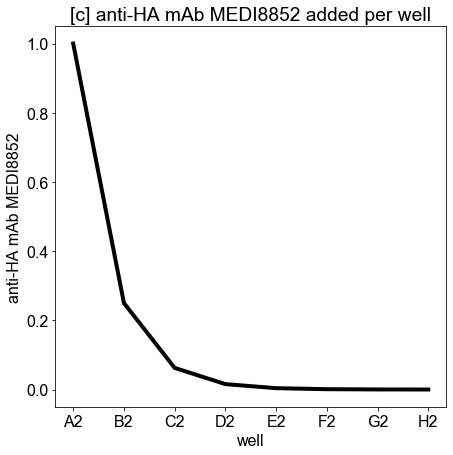

In [103]:
plt.figure(figsize=(7,7))
plt.plot(concentrations, lw=4, c='k')
plt.xticks(ticks=np.arange(len(concentrations)),labels=controlWells[0::2])
plt.xlabel('well')
plt.ylabel('anti-HA mAb MEDI8852')
plt.title('[c] anti-HA mAb MEDI8852 added per well');
#The plot for anti-HA mAb TF19 will look the same as this one, same concentrations per well but A3

## OD of xkappa-biotin should not change with concentration.

In [28]:
# Extract ODs across control wells and over all spots.
xkappaOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'xkappa-biotin'] for well in controlWells])
xkappaODMean=np.mean(xkappaOD, axis =1)

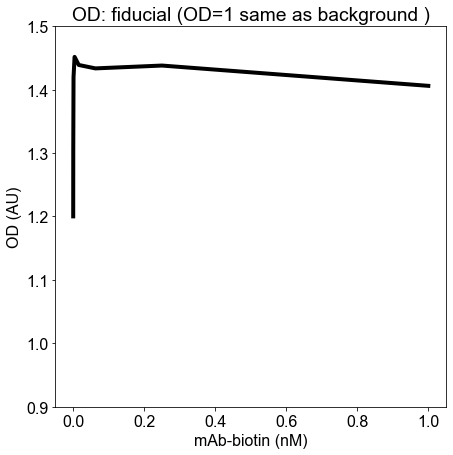

In [104]:
plt.figure(figsize=(7,7))
plt.plot(concentrations, xkappaODMean, lw=4, c='k')
plt.ylim([0.9,1.5])
plt.xlabel('mAb-biotin (nM)') #The flu plate does not have mAb-biotin, determine how this should change
plt.ylabel('OD (AU)')
plt.title('OD: fiducial (OD=1 same as background )');

## OD of GFP-foldon (-ve control) should be lower than fiducial

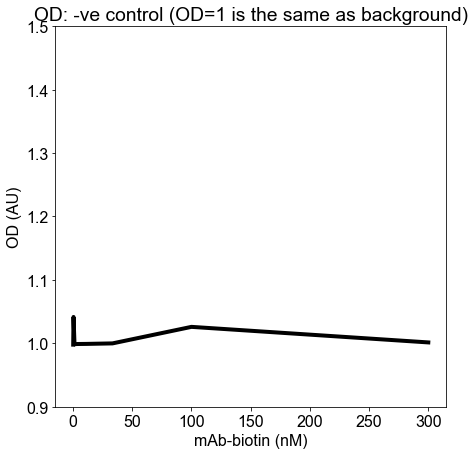

In [30]:
GFPfoldonOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'GFP-foldon'] for well in controlWells])
GFPfoldonODmean=np.mean(GFPfoldonOD, axis =1)
plt.figure(figsize=(7,7))
plt.plot(concentrations, GFPfoldonODmean, lw=4, c='k')
plt.ylim([0.9,1.5])
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD: -ve control (OD=1 is the same as background)');

## OD of  (+ve control) should be higher than fiducial

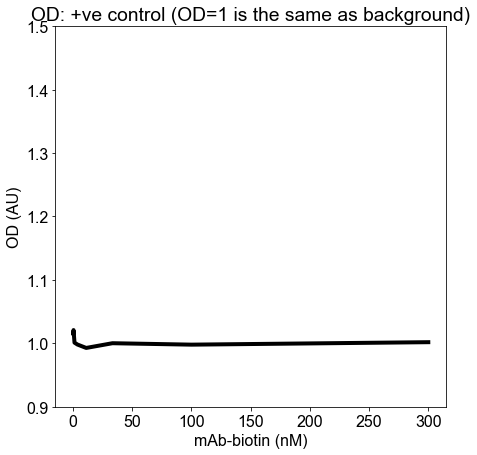

In [31]:
xmouseIgGOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'xmouse-IgG'] for well in controlWells])
xmouseIgGODmean=np.mean(xmouseIgGOD, axis =1)
plt.figure(figsize=(7,7))
plt.plot(concentrations, xmouseIgGODmean, lw=4, c='k')
plt.ylim([0.9,1.5])
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD: +ve control (OD=1 is the same as background)');

## +ve control didn't seem to work, let's look at images. 
spot 2-8 in raw data is +ve control (xmouse-IgG), and spot 5-8 is -ve control (GFP foldon). Plots match the data

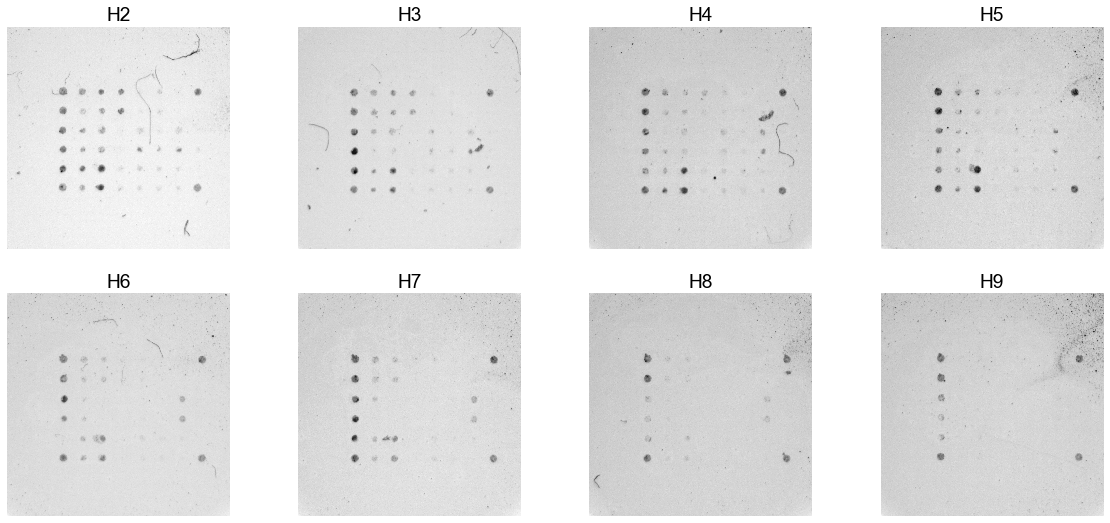

In [32]:
fig, ax = plt.subplots(2,int(len(controlWells)/2),figsize=(20,9))
ax=ax.flatten()
for n in range(8):
    wellImg=io.imread(os.path.join(data_folder,'20200327_analyzedPlate',controlWells[n]+'_crop.png'))
    ax[n].imshow(wellImg,cmap='gray')
    ax[n].set_title(controlWells[n])             
    ax[n].axis('off')

In [105]:
## Plot a standard curve using information from anti-HA mAb MEDI8852 wells

## Let's look at spot 16061 which shows some dynamic range over H1..H9.

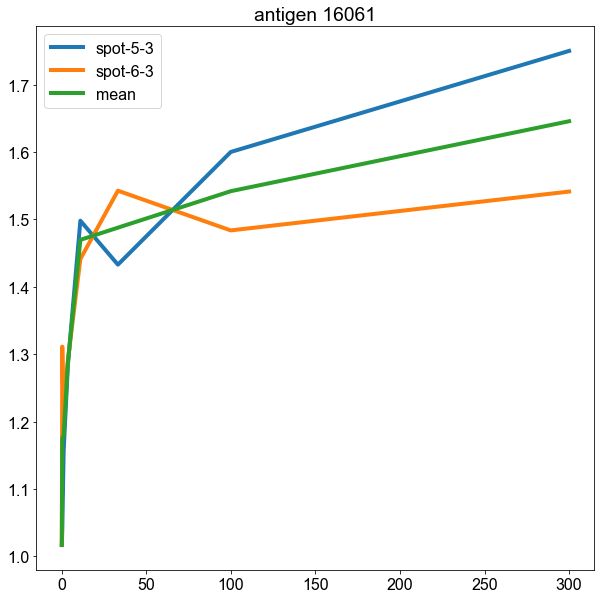

In [33]:
antigen16061=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '16061'] for well in controlWells])

plt.figure(figsize=(10,10))
plt.plot(concentrations,antigen16061,concentrations,np.mean(antigen16061,axis=1),lw=4 );
plt.legend(['spot-5-3','spot-6-3','mean'])
plt.title('antigen 16061');


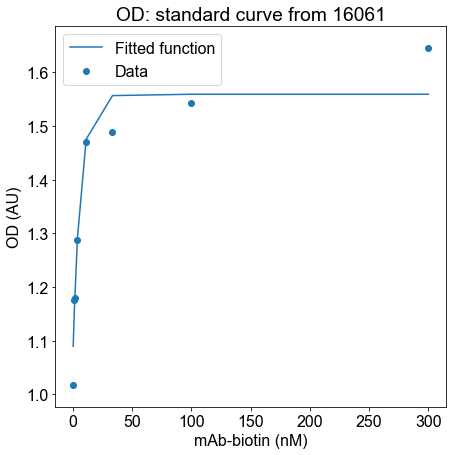

[-0.47964555  0.15729243  1.55899684]


In [34]:
# Try to fit
from scipy import optimize

# Flip the concentraiton (and ODs) in the increasing order.
concentrationListIncreasing=np.flip(concentrations)
flipWellMeans=np.flip(np.mean(antigen16061,axis=1))

def test_func(x, a, b, c):
    return a * np.exp(-b * x) + c

params, params_covariance = optimize.curve_fit(test_func, concentrationListIncreasing, flipWellMeans)

plt.figure(figsize=(7, 7))
plt.scatter(concentrationListIncreasing, flipWellMeans, label='Data')
plt.plot(concentrationListIncreasing, test_func(concentrationListIncreasing, params[0], params[1], params[2]),
         label='Fitted function')

plt.legend(loc='best')
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD: standard curve from 16061');

plt.show()
print(params)

## Compare OD curves for antigen 114 for mouse 2 vs mouse 6.

There are 2 biological replicates for each mouse: mouse 2 is columns 3 and 4, and mouse 6 is columns 11 and 12.
There are two technical replicates (spots) for antigen 114 in each well. 
Serial dilutions are across row-A to row-G, starting with 1:50 dilution in row-A.

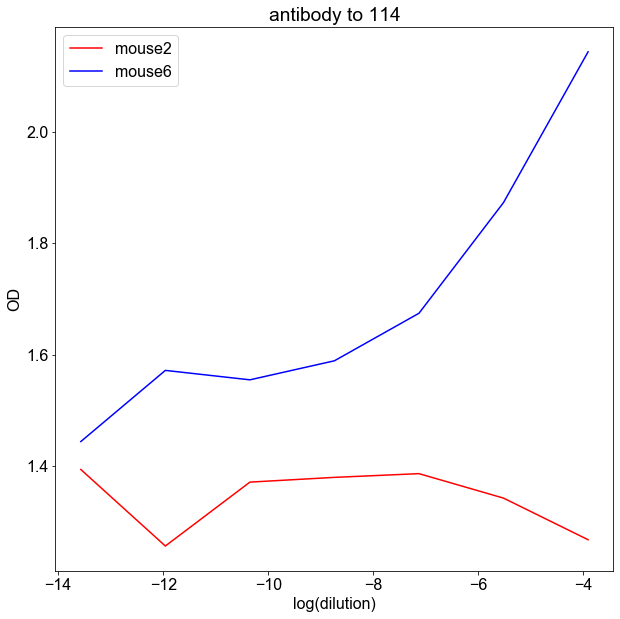

In [35]:
mouse2_rep1=['A3','B3','C3','D3','E3','F3','G3']
mouse2_rep2=['A4','B4','C4','D4','E4','F4','G4']
mouse6_rep1=['A11','B11','C11','D11','E11','F11','G11']
mouse6_rep2=['A12','B12','C12','D12','E12','F12','G12']

dilutions=[(1/50)/5**d for d in range(0,7)]

antigen114mouse2rep1=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse2_rep1])
antigen114mouse2rep1=np.mean(antigen114mouse2rep1,axis=1) # average within each well.
antigen114mouse2rep2=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse2_rep2])
antigen114mouse2rep2=np.mean(antigen114mouse2rep2,axis=1) # average within each well.
antigen114mouse2=0.5*(antigen114mouse2rep1+antigen114mouse2rep2) # average across wells.

antigen114mouse6rep1=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse6_rep1])
antigen114mouse6rep1=np.mean(antigen114mouse6rep1,axis=1) # average within each well.
antigen114mouse6rep2=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse6_rep2])
antigen114mouse6rep2=np.mean(antigen114mouse6rep2,axis=1) # average within each well.
antigen114mouse6=0.5*(antigen114mouse6rep1+antigen114mouse6rep2) # average across wells.

plt.figure(figsize=(10,10))
plt.plot(np.log(dilutions),antigen114mouse2,'r', np.log(dilutions),antigen114mouse6,'b')
plt.xlabel('log(dilution)') 
plt.ylabel('OD')
plt.title('antibody to 114')
plt.legend(['mouse2', 'mouse6'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))